<h2 style="background-color:powderblue; font-style: oblique"># Bank Customer Behavior Analysis</h2>
<p>
<img src="https://cdn.lynda.com/course/371321/371321-636283011013428914-16x9.jpg" width="600">
    </p>
    <hr>
<h3>Given a dataset consisiting of Bank Customer information, we want to build a classifier which will tell us if a customer will exit the bank or not.</h3>

In [0]:
import theano
import seaborn as sns
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

import os
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')
# print(os.listdir("../input"))

In [0]:
data = pd.read_csv("Churn_Modelling.csv")
# data.shape

In [180]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


RowNumber <br>
CustomerId <br>
Surname <br>
CreditScore <br>
Geography <br>
Gender <br>
Age <br>
Tenure <br>
Balance <br>
NumOfProducts -- How many accounts, bank account affiliated products the person has
HasCrCard <br>
IsActiveMember -- Subjective, but for the concept <br>
EstimatedSalary <br>
Exited -- Did they leave the bank after all? 

## Data preprocessing

In [5]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**drop columns which are unrelated **

In [0]:
# drop columns unmeaningful to our data 
drop_data = data.drop(columns=['RowNumber','CustomerId','Surname'])

In [8]:
drop_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
drop_data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
drop_data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
drop_data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
one_hot_encoder_data = pd.get_dummies(drop_data)
one_hot_encoder_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [13]:
one_hot_encoder_data.shape

(10000, 14)

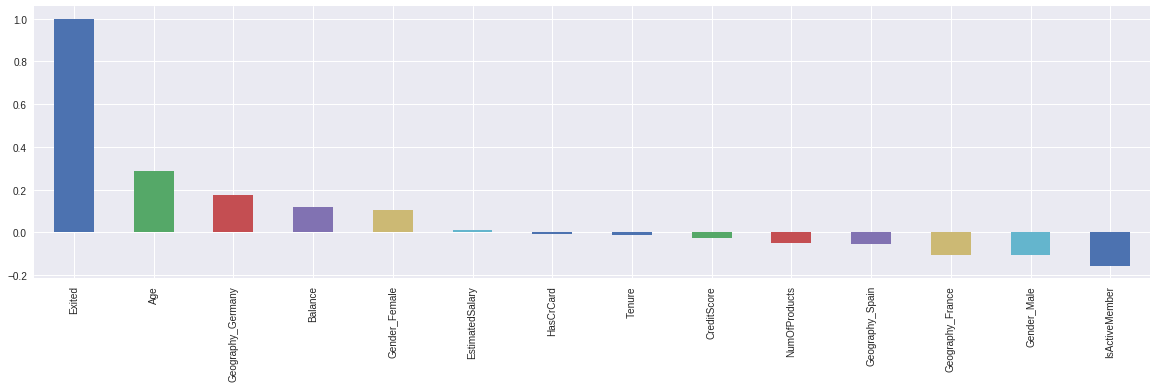

In [14]:
plt.figure(figsize=(20,5))
one_hot_encoder_data.corr()['Exited'].sort_values(ascending = False).plot(kind='bar')

** Looks like $Age$ and $Germany\_people$  is  postively related to our customer churn and $France\_people$ and $isActiveMember$ is most negatively correlated to our churn **

**So let's plot them**

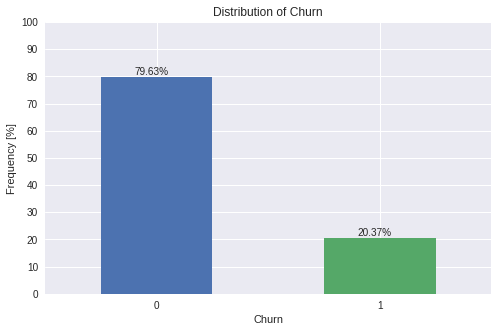

In [16]:
plt.figure(figsize=(8,5))
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Frequency [%]')

ax = (one_hot_encoder_data['Exited'].value_counts()/len(one_hot_encoder_data)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

### $Data Exploring$
<br>

Age Distribution - About half of the customers in our data set 25~40

In [0]:
def cut_to (x):
    if x>=18 and x<25:
        return "18~25"
    elif x>=25 and x<40:
        return "25~40"
    elif x>=40 and x< 60:
        return "40~60"
    else:
        return ">60"

In [18]:
one_hot_encoder_data['Group_age'] = one_hot_encoder_data['Age'].map(cut_to)
# one_hot_encoder_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Group_age
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0,40~60
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0,40~60
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0,40~60
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0,25~40
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0,40~60


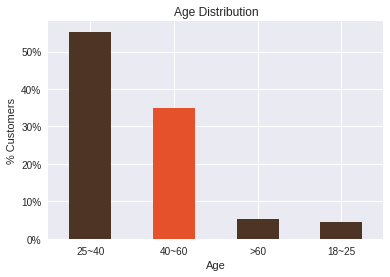

In [20]:
colors = ['#4D3425','#E4512B']
ax = (one_hot_encoder_data['Group_age'].value_counts()*100.0 /len(one_hot_encoder_data)).plot(kind='bar',stacked = True, rot = 0, color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customer')
ax.set_xlabel('Age')
ax.set_ylabel('% Customers')
ax.set_title('Age Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5,'',
            fontsize=12,
            color='white',
           weight = 'bold')

In [0]:
group_data = one_hot_encoder_data.groupby(['Group_age','Exited']).count()
group_data.reset_index(inplace=True)
# group_data.head()

Text(0,0.5,'Num')

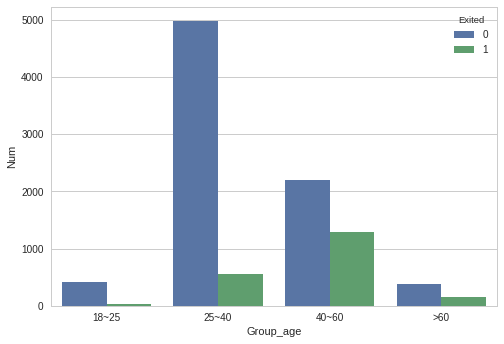

In [23]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Group_age', y='Age', 
                 hue='Exited',data=group_data)
ax.set_ylabel('Num')


In [24]:
one_hot_encoder_data = one_hot_encoder_data.drop(columns=['Group_age'])
one_hot_encoder_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


**%isActiveMember**  active and inactive members account almost half and half

Text(0.5,1,'% of ActiveMember')

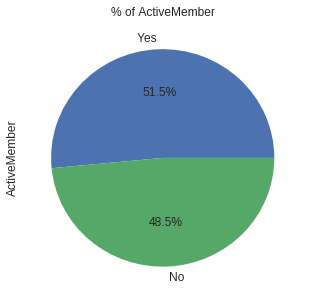

In [25]:
ax = (one_hot_encoder_data['IsActiveMember'].value_counts()*100.0 /len(one_hot_encoder_data)).plot.pie(autopct='%.1f%%', labels = ['Yes', 'No'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('ActiveMember',fontsize = 12)
ax.set_title('% of ActiveMember', fontsize = 12)

**Let's see area dimension**  - About 50% are France and Germany and Spain constitute half of rest of the space , respectively

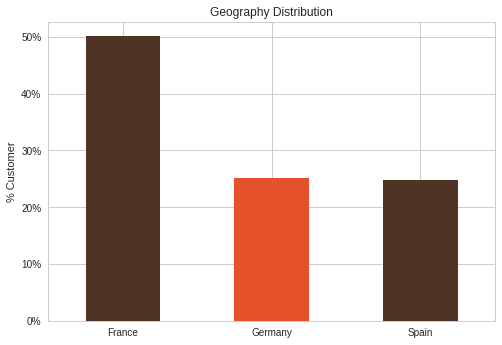

In [0]:
colors = ['#4D3425','#E4512B']
ax = (drop_data['Geography'].value_counts()*100.0 /len(drop_data)).plot(kind='bar',stacked = True, rot = 0, color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customer')
ax.set_title('Geography Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5,'',
            fontsize=12,
            color='white',
           weight = 'bold')

In [0]:
group_data = drop_data.groupby(['Geography','Exited']).count()
group_data.reset_index(inplace=True)
group_data.head()

,Geography,Exited,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,France,0,4204,4204,4204,4204,4204,4204,4204,4204,4204
1,France,1,810,810,810,810,810,810,810,810,810
2,Germany,0,1695,1695,1695,1695,1695,1695,1695,1695,1695
3,Germany,1,814,814,814,814,814,814,814,814,814
4,Spain,0,2064,2064,2064,2064,2064,2064,2064,2064,2064


Text(0,0.5,'Num')

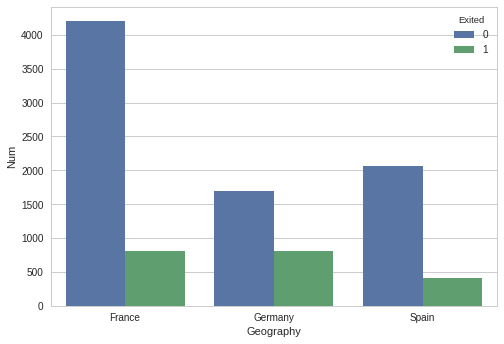

In [0]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Geography', y='Age', 
                 hue='Exited',data=group_data)
ax.set_ylabel('Num')

### Correlation of data

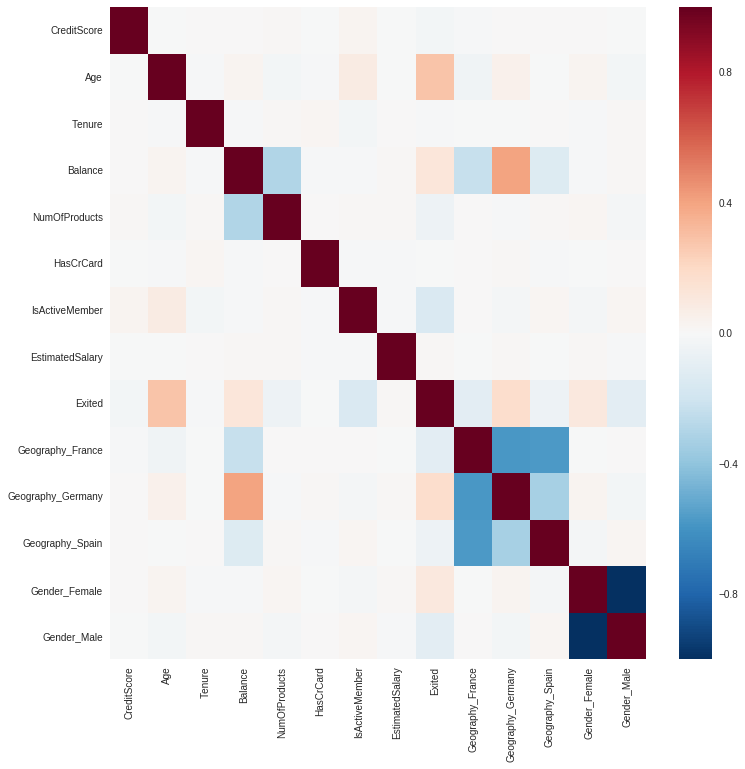

In [26]:
plt.subplots(figsize=(12,12))
# sns.heatmap(corr)
corr = one_hot_encoder_data.corr();
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


** Finally Let's take a look at our predictor (Customer churn) **


In [27]:
one_hot_encoder_data['exited'] = one_hot_encoder_data['Exited']
one_hot_encoder_data = one_hot_encoder_data.drop(columns=['Exited'])
one_hot_encoder_data.head()
                          

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,exited
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,1
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0,0


In [0]:
X = one_hot_encoder_data.iloc[:,:-1].values # Credit Score through Estimated Salary
Y = one_hot_encoder_data.iloc[:, -1].values # Exited

In [0]:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 13)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
sc=StandardScaler()
# lb=preprocessing.LabelEncoder()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Logistic Regression


**Process Imbalanced Data with SMOTE**

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,Y_tr = sm.fit_sample(X_train,Y_train)

In [55]:
from sklearn.linear_model import LogisticRegression
# 
classifier = LogisticRegression()
classifier.fit(X_tr, Y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 0, 1])

In [57]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y_test, y_pred)
print("Our accuracy is {}%".format(((matrix[0][0] + matrix[1][1])/(matrix[0][0] + matrix[0][1] +  matrix[1][0] +matrix[1][1]))*100))

Our accuracy is 71.2%


## ANN


In [0]:
import keras #
from keras.models import Sequential
from keras.layers import Dense

In [0]:
from sklearn.utils import shuffle
# one_hot_encoder_data = shuffle(one_hot_encoder_data)
X = one_hot_encoder_data.iloc[:,:-1].values # Credit Score through Estimated Salary
Y = one_hot_encoder_data.iloc[:, -1].values # Exited
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 30)
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,Y_tr = sm.fit_sample(X_train,Y_train)

In [0]:
classifier = Sequential()
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
classifier.add(Dense(activation = 'relu', input_dim = 13 , units=20, kernel_initializer='uniform'))

In [0]:
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
classifier.add(Dense(activation = 'relu', units=20, kernel_initializer='uniform')) 
classifier.add(Dense(activation = 'relu', units=25, kernel_initializer='uniform'))
classifier.add(Dense(activation = 'relu', units=30, kernel_initializer='uniform'))
# # classifier.add(Dense(activation = 'relu', units=40, kernel_initializer='uniform'))
# classifier.add(Dense(activation = 'relu', units=44, kernel_initializer='uniform'))
# # classifier.add(Dense(activation = 'relu', units=30, kernel_initializer='uniform'))
# classifier.add(Dense(activation = 'relu', units=40, kernel_initializer='uniform')) 


In [0]:
classifier.add(Dense(activation = 'sigmoid', units=1, kernel_initializer='uniform')) 

In [0]:
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [123]:
classifier.fit(X_tr, Y_tr, batch_size=25, epochs=300)

Epoch 1/300
12680/12680 [==============================] - 1s 81us/step - loss: 0.5577 - acc: 0.7166
Epoch 2/300
12680/12680 [==============================] - 1s 53us/step - loss: 0.4629 - acc: 0.7761
Epoch 3/300
12680/12680 [==============================] - 1s 52us/step - loss: 0.4550 - acc: 0.7799
Epoch 4/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4502 - acc: 0.7842
Epoch 5/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4461 - acc: 0.7878
Epoch 6/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4429 - acc: 0.7849
Epoch 7/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4388 - acc: 0.7909
Epoch 8/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4345 - acc: 0.7916
Epoch 9/300
12680/12680 [==============================] - 1s 49us/step - loss: 0.4320 - acc: 0.7936
Epoch 10/300
12680/12680 [==============================] - 1s 50us/step - loss: 0.4318 - a

In [124]:
Y_pred = classifier.predict(X_test)
Y_pred = (Y_pred > 0.5)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y_test, Y_pred)
print("Our accuracy is {}%".format(((matrix[0][0] + matrix[1][1])/(matrix[0][0] + matrix[0][1] +  matrix[1][0] +matrix[1][1]))*100))

Our accuracy is 80.5%


## Decesion Tree


### Default parameters

In [0]:
from sklearn.tree import DecisionTreeClassifier


In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,Y_tr = sm.fit_sample(X_train,Y_train)

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fitting the decision tree with default hyperparameters, apart from
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_tr, Y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
# dot_data = tree.export_graphviz(dt1, out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render("iris")


In [142]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
X_test = pd.DataFrame(data=X_test).iloc[:, :]
y_pred2 = dt1.predict(X_test)

# Printing classification report
print(classification_report(Y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1623
           1       0.40      0.75      0.52       377

   micro avg       0.74      0.74      0.74      2000
   macro avg       0.66      0.74      0.67      2000
weighted avg       0.83      0.74      0.76      2000



In [143]:
# Printing confusion matrix and accuracy
print(confusion_matrix(Y_test, y_pred2))
print('Accuracy of Decision Tree :',accuracy_score(Y_test, y_pred2))

[[1190  433]
 [  93  284]]
Accuracy of Decision Tree : 0.737


### Tuning max_depth

In [144]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dt2 = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dt2, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [145]:
score = tree.cv_results_
pd.DataFrame(score).head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.01,0.00,0.71,0.71,1,{'max_depth': 1},39,0.69,0.72,0.71,...,0.72,0.71,0.72,0.71,0.71,0.71,0.00,0.00,0.01,0.00
1,0.01,0.00,0.73,0.73,2,{'max_depth': 2},38,0.71,0.73,0.73,...,0.74,0.73,0.74,0.73,0.72,0.73,0.00,0.00,0.01,0.00
2,0.02,0.00,0.74,0.74,3,{'max_depth': 3},37,0.72,0.75,0.74,...,0.74,0.73,0.75,0.74,0.74,0.74,0.00,0.00,0.01,0.01
3,0.03,0.00,0.76,0.77,4,{'max_depth': 4},36,0.71,0.77,0.78,...,0.78,0.77,0.77,0.75,0.74,0.76,0.00,0.00,0.02,0.01
4,0.03,0.00,0.79,0.80,5,{'max_depth': 5},35,0.73,0.79,0.80,...,0.80,0.80,0.82,0.79,0.79,0.80,0.00,0.00,0.03,0.00
5,0.04,0.00,0.80,0.81,6,{'max_depth': 6},34,0.74,0.81,0.81,...,0.82,0.82,0.83,0.81,0.81,0.82,0.00,0.00,0.03,0.00
6,0.04,0.00,0.81,0.83,7,{'max_depth': 7},33,0.73,0.84,0.81,...,0.83,0.83,0.84,0.82,0.81,0.83,0.00,0.00,0.04,0.01
7,0.05,0.00,0.81,0.84,8,{'max_depth': 8},32,0.74,0.85,0.82,...,0.83,0.84,0.84,0.83,0.82,0.84,0.00,0.00,0.04,0.00
8,0.05,0.00,0.81,0.86,9,{'max_depth': 9},31,0.73,0.87,0.81,...,0.85,0.85,0.84,0.85,0.83,0.86,0.00,0.00,0.04,0.01
9,0.06,0.00,0.82,0.88,10,{'max_depth': 10},30,0.74,0.89,0.82,...,0.84,0.88,0.85,0.87,0.83,0.87,0.00,0.00,0.04,0.01


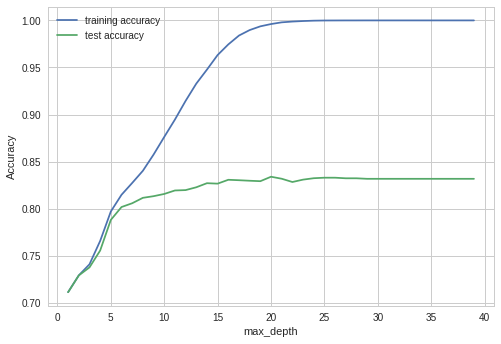

In [146]:
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<i>According to this plot above, the  optimal max_depth seems fall in (5,25)</i>

### Tuning min_samples_leaf

In [147]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [148]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.07,0.00,0.82,0.93,5,{'min_samples_leaf': 5},1,0.72,0.94,0.82,...,0.85,0.92,0.85,0.92,0.86,0.92,0.00,0.00,0.05,0.01
1,0.06,0.00,0.81,0.85,25,{'min_samples_leaf': 25},2,0.71,0.87,0.82,...,0.83,0.85,0.84,0.85,0.83,0.85,0.00,0.00,0.05,0.01
2,0.05,0.00,0.80,0.84,45,{'min_samples_leaf': 45},5,0.70,0.85,0.80,...,0.83,0.83,0.84,0.83,0.82,0.83,0.00,0.00,0.05,0.01
3,0.05,0.00,0.80,0.83,65,{'min_samples_leaf': 65},6,0.72,0.84,0.81,...,0.82,0.82,0.83,0.82,0.81,0.82,0.00,0.00,0.04,0.01
4,0.04,0.00,0.80,0.82,85,{'min_samples_leaf': 85},3,0.75,0.84,0.80,...,0.82,0.82,0.83,0.82,0.81,0.82,0.00,0.00,0.03,0.01


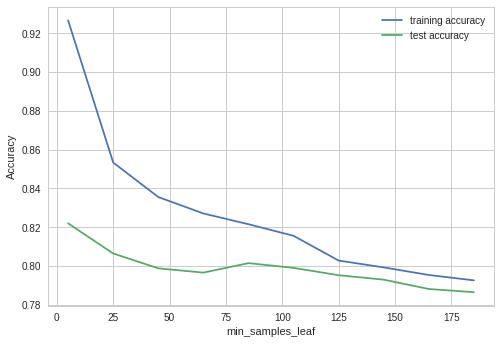

In [149]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**According to this plot above, the optimal min_samples_leaf seems fall in (10,100)**

### Tuning min_samples_split

In [150]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree2 = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree2.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

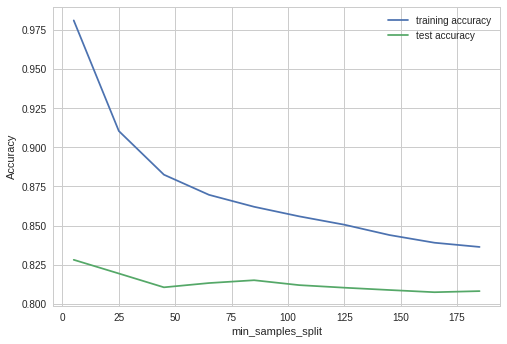

In [75]:
# plotting accuracies with min_samples_leaf
scores = tree2.cv_results_
plt.figure()

plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**best Min_samples_splits seems fall in the range(25,250)**

In [151]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 4),
    'min_samples_leaf': range(10, 100, 50),
    'min_samples_split': range(25, 250, 20),
    'criterion': ["entropy", "gini"]
}

n_folds = 6

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1,n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_tr, Y_tr)

Fitting 6 folds for each of 192 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   53.6s finished


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(5, 20, 4), 'min_samples_leaf': range(10, 100, 50), 'min_samples_split': range(25, 250, 20), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [77]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_, "Using: ",grid_search.best_estimator_)


Best Accuracy 0.8202844194405375 Using:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=85,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### Final Tree

In [152]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=85,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
clf_gini.fit(X_tr, Y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=85,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [153]:
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,Y_test))

Accuracy Score for Decision Tree Final Model : 0.802


In [154]:
X_tr.shape

(12680, 13)

## Random Forest

### Default parameters

In [0]:
from sklearn.utils import shuffle
one_hot_encoder_data = shuffle(one_hot_encoder_data)
X = one_hot_encoder_data.iloc[:,:-1].values # Credit Score through Estimated Salary
Y = one_hot_encoder_data.iloc[:, -1].values # Exited
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 25)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
sc=StandardScaler()
lb=preprocessing.LabelEncoder()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,Y_tr = sm.fit_sample(X_train,Y_train)

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_tr, Y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(Y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.8245


### Tuning max_depth

In [158]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

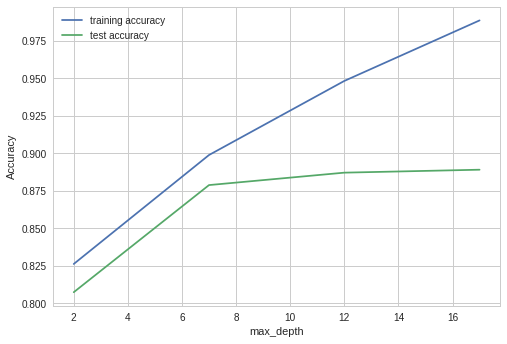

In [159]:
scores = rf.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tuning min_samples_leaf

In [160]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(50, 400, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

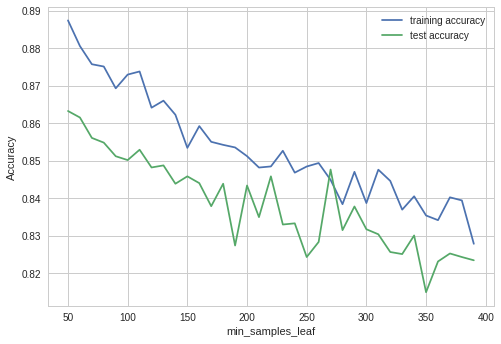

In [161]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tuning min_samples_split

In [162]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_tr, Y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(100, 500, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

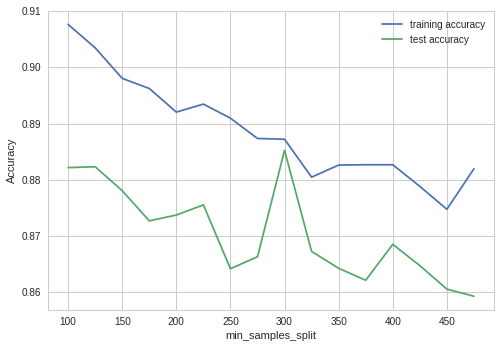

In [163]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(100, 250, 50),
    'min_samples_split': range(100, 350, 50),
    'n_estimators': [500,700], 
    'max_features': range(1, 13, 3)
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

**cell below takes long time**

In [0]:
#Commenting as it takes long time
# Fit the grid search to the data
grid_search.fit(X_tr, Y_tr)
# printing the optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 48.6min finished


Accuracy is 0.804177135678392 using {'max_depth': 12, 'max_features': 7, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 700}


### Final Forest

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 25)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=12,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=700 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 7,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, Y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=7, max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=True, random_state=50, verbose=0, warm_start=False)

In [166]:
prediction_test = model_rf.predict(X_test)
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test,prediction_test))
print(confusion_matrix(Y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1624
           1       0.70      0.32      0.44       376

   micro avg       0.85      0.85      0.85      2000
   macro avg       0.78      0.64      0.68      2000
weighted avg       0.83      0.85      0.82      2000

[[1571   53]
 [ 255  121]]


In [167]:
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(Y_test, prediction_test))

Accuracy Score for Random Forest Final Model : 0.846


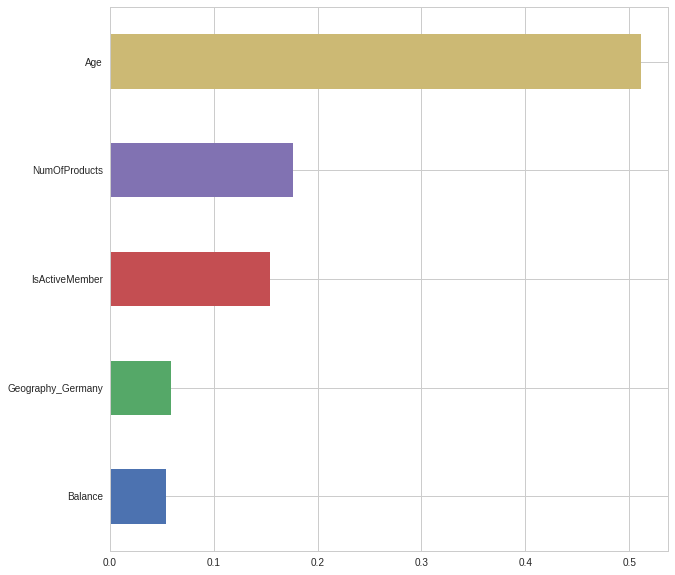

In [168]:
X = one_hot_encoder_data.drop(columns=['exited'])
# importances=model_rf.feature_importances_
# importances
# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
plt.subplots(figsize=(10,10))

weights.sort_values()[-5:].plot(kind = 'barh')

**Accurancy:**

**Logistic Regression:  71.2%**

**ANN : 80%**

**Desision Tree:  73.7%**
**Tuning tree:80.2%**

**Random Forest: 82.45%**
**Tuning Forest: 84.6%**



Summary:

Among these results, the Random Forest with optimal parameters can get best classification result with 84.6%

And it turns out that the Age, NumOfProducts, isActiveMember, Geography_Germany, Balance might influence customer's churn behavior :)
